# LSST Solar System Processing

## Linking of Observations from JPL Veres & Chesley dataset via HelioLinC2

### Algorithm: 

Based on HelioLinC (Holman et al. 2018) we transform topocentric observations to heliocentric states assuming a distance and radial velocity.
The resulting 3D positions are collected into tracklets. Tracklets contain at least two observations and can, thus, be used to create velocity vectors.
A tracklet + velocity vector is called an "arrow". 
Arrows are propagated to a common epoch using spiceypy's 2body propagator, and then clustered using dbscan.

### Implementation:
S. Eggl 20191215
    

In [1]:
# Solar System Processing functions
import heliolinc2 as ls

ModuleNotFoundError: No module named 'heliolinc2'

In [2]:
import constants as cnst
import vector as vec
import transforms as tr
import propagate as prop
import ephemeris as ephem
import filterclusters as fc
import performancecheck as pc
import plot as pl

In [3]:
#Accelerators
import numpy as np

#Database
import pandas as pd

#Plotting
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

#Timing
import time
from datetime import datetime


In [4]:
# Joblib prallelization
import joblib
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects
from joblib import Parallel, delayed

In [5]:
# Progress bar for joblib processes
import contextlib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback:
        def __init__(self, time, index, parallel):
            self.index = index
            self.parallel = parallel

        def __call__(self, index):
            tqdm_object.update()
            if self.parallel._original_iterator is not None:
                self.parallel.dispatch_next()

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()   

## SIMULATED OBSERVATIONS 


1) Select observations from JPL Dataset

In [7]:
%%time
# Veres & Chesley 2017, 5deg x 5deg, 14 days 
dfveres= pd.read_csv('Veres_5x5deb_14nights.tar.gz',sep=',', skiprows=0).dropna().astype({'objId': 'int64','night': 'int32', 'obsId':'int64'} )

CPU times: user 155 ms, sys: 25 ms, total: 180 ms
Wall time: 181 ms


In [8]:
dfjpl=dfveres.rename(columns={"Veres_5x5deb_14nights.csv": "obj"})

2) Extract epochs of observations and query JPL Horizons for the corresponding observer states

In [9]:
#Observer location MPC code
observer_location='I11'
#Epochs of observation
obs_epochs=tr.mjd2jd(dfjpl['time'].values)
#time between observations
ephemeris_dt='1h'

In [10]:
[observer_xyz, observer_vxyz]=ephem.getObserverStates(obs_epochs,observer_location,ephemeris_dt)

[[-8.18439761e-01 -5.85272681e-01 -2.72019734e-05]
 [-8.18038982e-01 -5.85865749e-01 -2.38197419e-05]
 [-8.17635440e-01 -5.86459367e-01 -2.00717895e-05]
 ...
 [-6.47114734e-01 -7.75424965e-01 -1.47328968e-05]
 [-6.46575496e-01 -7.75895816e-01 -1.09099689e-05]
 [-6.46033435e-01 -7.76365937e-01 -7.23589057e-06]]
[[ 9.58777826e-03 -1.42226215e-02  7.48709655e-05]
 [ 9.65087522e-03 -1.42425042e-02  8.65477870e-05]
 [ 9.71976234e-03 -1.42487759e-02  9.23247140e-05]
 ...
 [ 1.29073691e-02 -1.13043206e-02  9.14304993e-05]
 [ 1.29759779e-02 -1.12940712e-02  9.10104058e-05]
 [ 1.30422318e-02 -1.12693680e-02  8.43267519e-05]]


In [11]:
dfobs=dfjpl

In [12]:
dfobs['x_obs']=observer_xyz[:,0]
dfobs['y_obs']=observer_xyz[:,1]
dfobs['z_obs']=observer_xyz[:,2]
dfobs['vx_obs']=observer_vxyz[:,0]
dfobs['vy_obs']=observer_vxyz[:,1]
dfobs['vz_obs']=observer_vxyz[:,2]

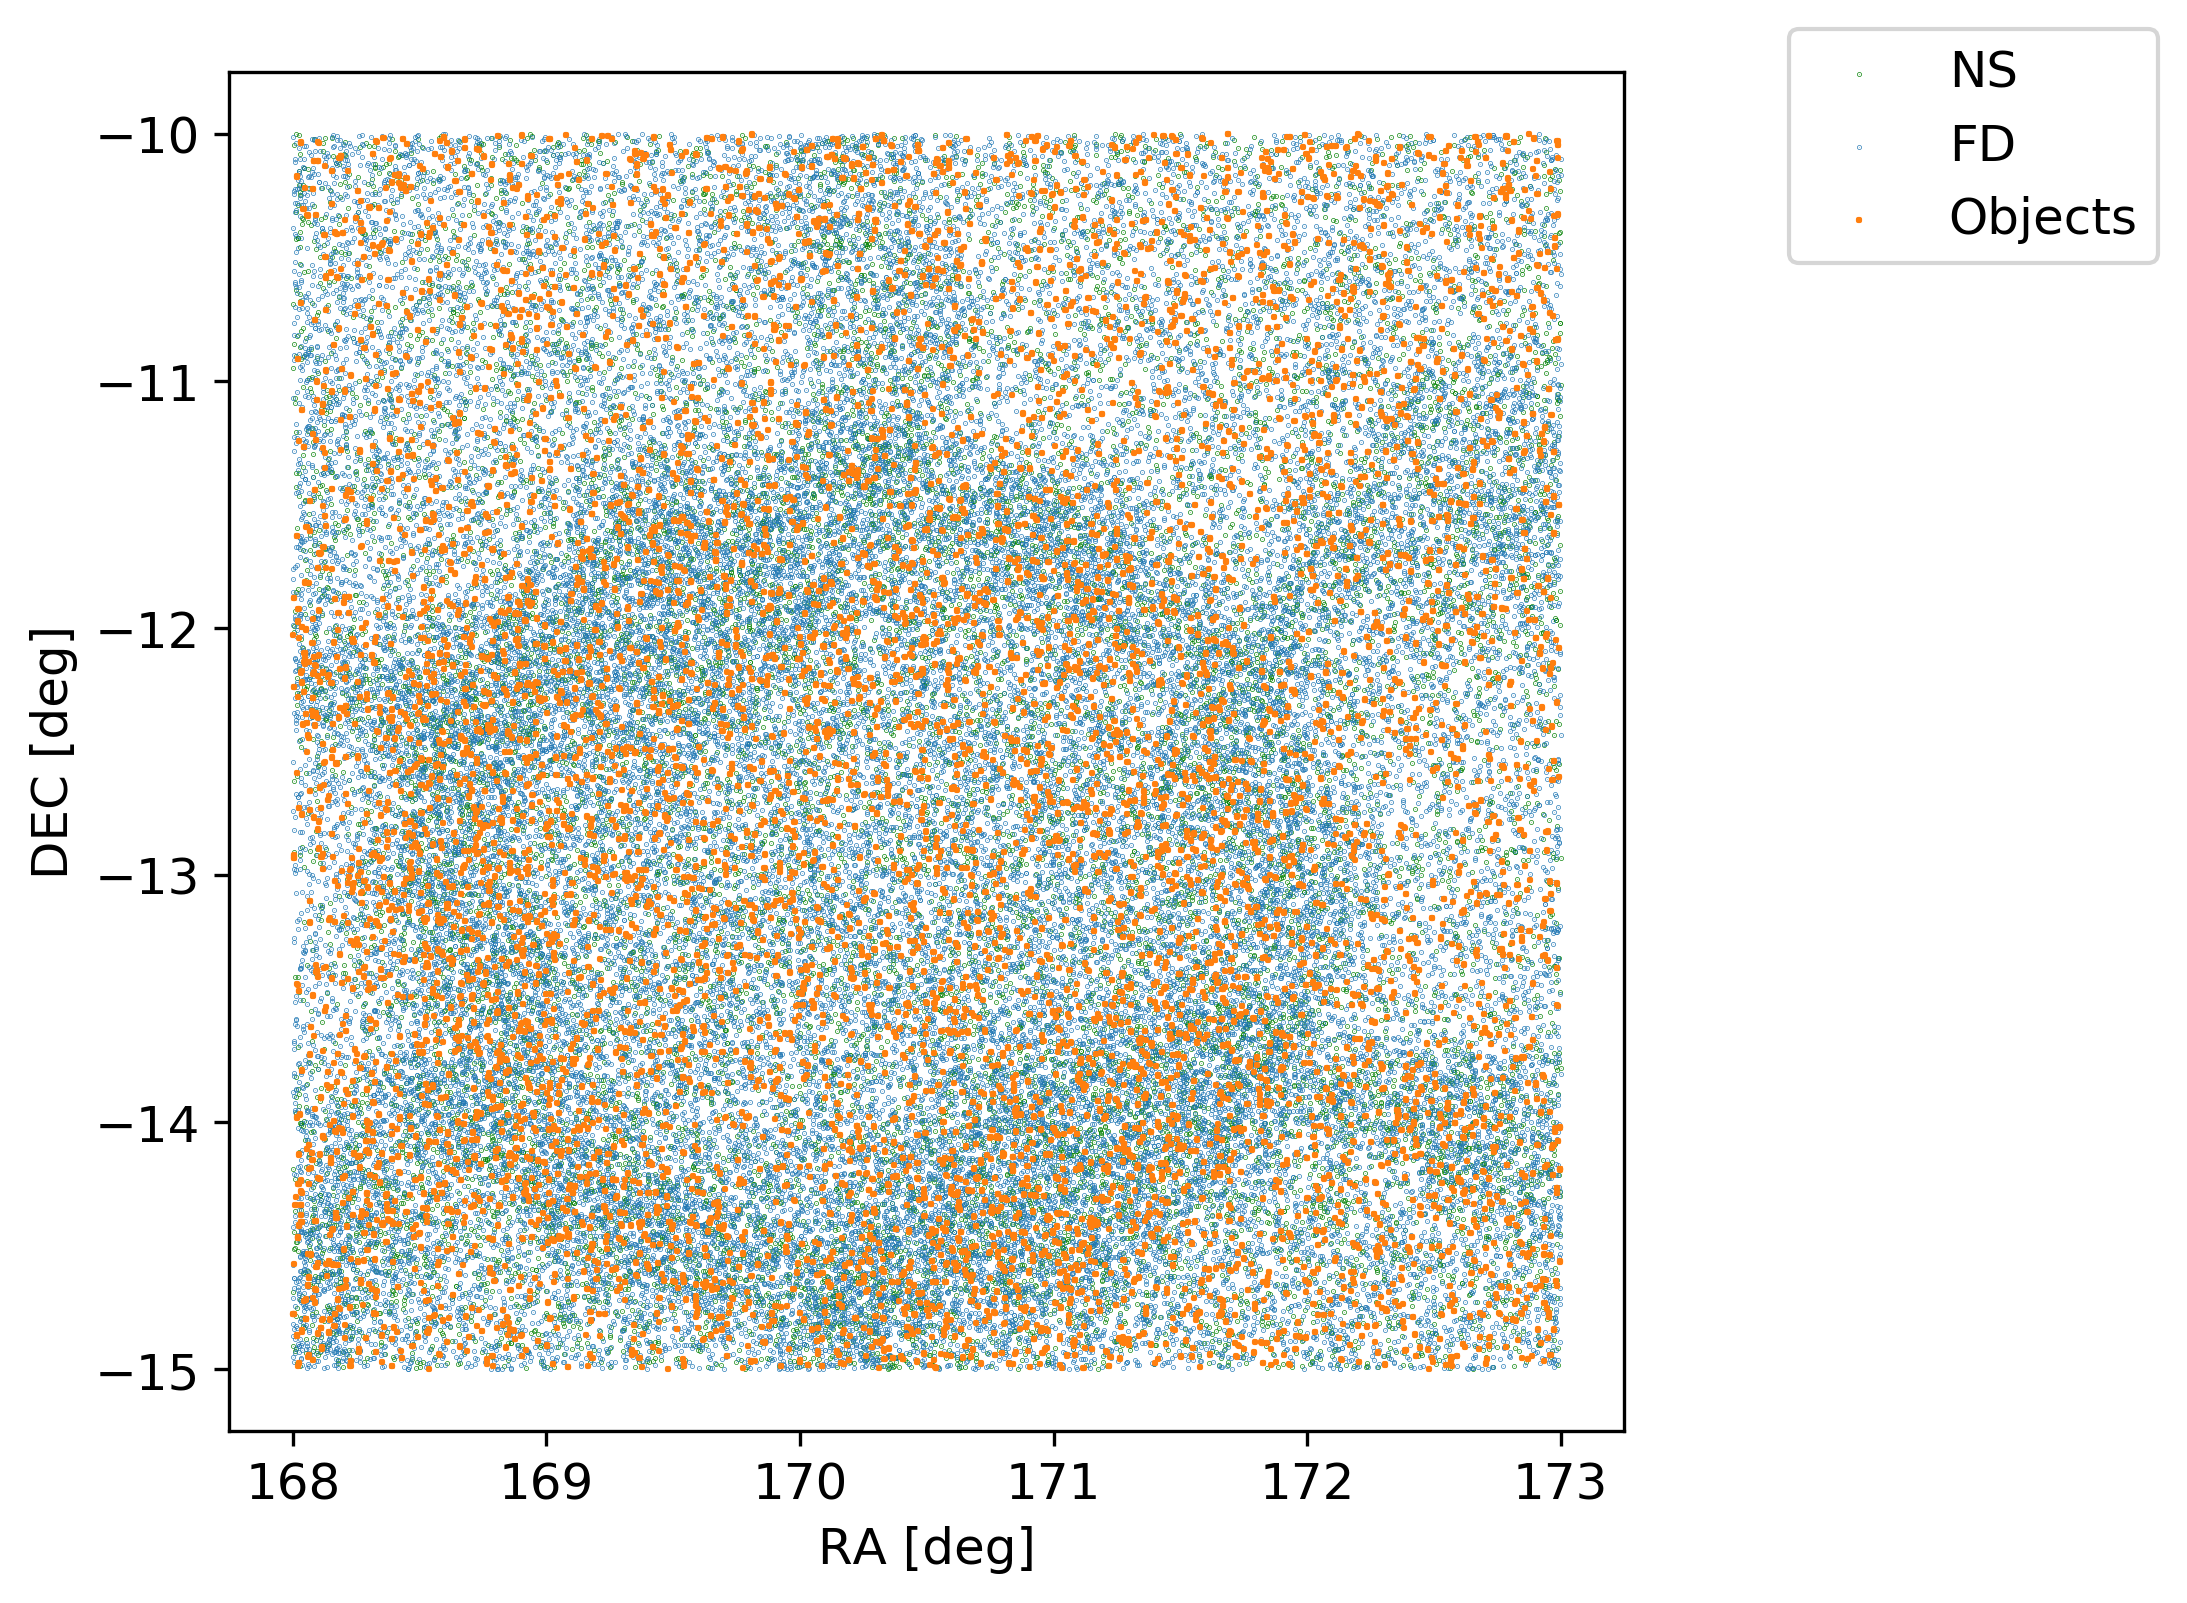

In [13]:
plot_field(dfobs)

## Signal to Noise in the chosen field 

In [14]:
# collect data from different categories
dfobs_FD=dfobs.iloc[dfobs['obj'].values=='FD']
dfobs_NS=dfobs.iloc[dfobs['obj'].values=='NS']
dfobs_obj=dfobs.drop(dfobs_FD.index).drop(dfobs_NS.index)
SNR_field=len(dfobs_obj.index)/(len(dfobs_NS.index)+len(dfobs_FD.index))
print(SNR_field)

0.26722774053595605


## Source Density per square degree


In [15]:
np.rint(len(dfobs.index)/(5*5))

3108.0

Check observation dataframe: must contain time, RA, DEC, x_obs, y_obs, z_obs, vx_obs, vy_obs, vz_obs, night, obsId, objId

In [16]:
dfobs[0:10]

obj          time          RA        DEC     x_obs     y_obs  \
0  S1009GjOa  52391.002282  171.368899 -12.504937 -0.808597 -0.599239   
1  S1001QUsa  52391.002282  169.318742 -13.021633 -0.808597 -0.599239   
2  S10036B8a  52391.002282  170.375067 -12.218251 -0.808597 -0.599239   
3  S100aAWQa  52391.002282  171.392970 -14.233830 -0.808597 -0.599239   
4  S1001DTsa  52391.002282  171.308411 -14.222651 -0.808597 -0.599239   
5  S1008Q8Da  52391.002282  170.582069 -12.248939 -0.808597 -0.599239   
6  S100dQNoa  52391.002282  168.832741 -12.103015 -0.808597 -0.599239   
7  S1004whRa  52391.002282  171.183715 -13.576337 -0.808597 -0.599239   
8  S1000gIia  52391.002282  169.879839 -11.317941 -0.808597 -0.599239   
9  S100a4cua  52391.002282  170.612881 -11.978926 -0.808597 -0.599239   

      z_obs    vx_obs    vy_obs    vz_obs  night  obsId  objId  
0 -0.000026  0.009826 -0.014054  0.000076      0      0    839  
1 -0.000026  0.009826 -0.014054  0.000076      0      1    164  
2 -0.000026  0.009826 -0.014054  0.000076      0      2    319  
3 -0.000026  0.009826 -0.014054  0.000076      0      3   1580  
4 -0.000026  0.009826 -0.014054  0.000076      0      4    144  
5 -0.000026  0.009826 -0.014054  0.000076      0      5    766  
6 -0.000026  0.009826 -0.014054  0.000076      0      6   1835  
7 -0.000026  0.009826 -0.014054  0.000076      0      7    491  
8 -0.000026  0.009826 -0.014054  0.000076      0      8     96  
9 -0.000026  0.009826 -0.014054  0.000076      0      9   1570

Since we are looking at a fraction of the sky, how many nights do we actually observe?

In [17]:
df_grouped_by_night=dfobs.groupby('night')

In [18]:
len(df_grouped_by_night.groups)

7

In [19]:
df_grouped_by_night.groups.keys()

dict_keys([0, 1, 3, 6, 10, 11, 13])

## Run HelioLinC2

Choose HelioLinC2 clustering parameters

In [20]:
# Clustering radius for heliocentric positions projected from observations [au]
cr_obs=0.02
# Clustering radius for propagated arrows [au]
cr_arrows=0.002
# max temporal separation for tracklet observations (days)
ct_max=8/24
# min temporal separation for tracklet observations, e.g. exposure time (days)
ct_min=15/86400 
# Minimum number of arrows to be clustered ('DBSCAN only')
min_samples=3

In [21]:
#test

# %load_ext autoreload

# %autoreload

# %reload_ext heliolinc2

# ls.heliolinc2(dfobs, 2, 0, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
#                                        clustering_algorithm='dbscan', light_time=False, 
#                                        verbose=True, n_jobs=1) 

In [22]:
# define range of heliocentric distances
rall=np.arange(2,3.7,0.05)

# define range of heliocentric radial velocities
drdtall=np.arange(-0.05,0.051,0.01)

# Iterator for joblib based paralellization
rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

# How many configuraitons do we have to run?
len(rrdot)


374

In [23]:
with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
    clusters_df=Parallel(n_jobs=14)(delayed(ls.heliolinc2)
                                      (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                       clustering_algorithm='dbscan', light_time=False, 
                                       verbose=False, n_jobs=1) 
                                       for r, drdt in rrdot ) 
    

HelioLinC2:   4%|▍         | 15/374 [31:47<20:50:03, 208.92s/it] /epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

HelioLinC2: 100%|██████████| 374/374 [3:10:32<00:00, 30.57s/it]   


In [24]:
print('total number of dataframes:',len(clusters_df))

total number of dataframes: 374


In [25]:
clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
clustered_observations['clusterId']=clustered_observations.index
len(clustered_observations)

273223

In [26]:
#%load_ext autoreload

# %autoreload

# %reload_ext filterclusters

In [27]:
# obs_lens=[]

# for index, row in clustered_observations.iterrows():
#     #print(row['obsId'])
#     obs_lens.append(len(row['obsId']))

In [28]:
# plt.figure(dpi=150)
# plt.hist(obs_lens,bins=range(1,20))
# plt.ylim(1,)
# plt.xlim(1,20)
# plt.xlabel('number of observations in cluster')
# plt.ylabel('number of clusters')

In [29]:
# idx=clustered_observations['obsId'][0]

In [30]:
# l_dict=zip(idx,idx)

In [31]:
# df=dfobs[[x in idx for x in dfobs['obsId']]]

In [32]:
# df

In [33]:
# drop_idx=fc.filterClusters(dfobs, clustered_observations, rms_max=3, filter_type='mean_state')
# 

In [34]:
# def parallelize_filter(df, dfobs, func, n_cores=12):
#     df_split = np.array_split(df, n_cores)
#     pool = Pool(n_cores)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df


In [35]:
n_cores=25

dfobs_n=[]
for i in range(n_cores):
    dfobs_n.append(dfobs)

df_split = np.array_split(clustered_observations, n_cores)  

In [36]:
with tqdm_joblib(tqdm(desc="HelioLinC2", total=n_cores)) as progress_bar:
    drop_idx=Parallel(n_jobs=n_cores)(delayed(fc.filterClusters)
                       (dfobs_n[i], df_split[i] , rms_max=2, filter_type='mean_state') for i in range(n_cores) )  
  

HelioLinC2: 100%|██████████| 25/25 [3:54:54<00:00, 563.79s/it]    


In [37]:
drop_idx

[       clusterId                         obsId    r  drdt  cluster_epoch  \
 101          101               [4, 2521, 5878]  2.0 -0.05   52397.573056   
 133          133        [77, 2531, 3390, 5888]  2.0 -0.05   52397.573056   
 143          143        [87, 2532, 3398, 5890]  2.0 -0.05   52397.573056   
 290          290        [53, 2529, 3372, 5885]  2.0 -0.05   52397.573056   
 291          291       [171, 2560, 3480, 5916]  2.0 -0.05   52397.573056   
 ...          ...                           ...  ...   ...            ...   
 10714      10714         [21186, 28245, 39319]  2.0 -0.01   52397.573056   
 10717      10717         [21249, 28310, 39377]  2.0 -0.01   52397.573056   
 10720      10720         [21279, 28341, 39405]  2.0 -0.01   52397.573056   
 10722      10722         [21270, 28331, 39395]  2.0 -0.01   52397.573056   
 10834      10834  [41686, 42567, 44434, 45275]  2.0 -0.01   52397.573056   
 
             x_a       y_a       z_a      vx_a      vy_a      vz_a       r

In [38]:
# Filter all indices with RMS > RMS_limit
# drop_idx2=np.array(drop_idx)
# drop_idx3=drop_idx2[drop_idx2[:,1]==1]

In [39]:
# drop_idx2[:,3]

In [40]:
# drop_idx2

In [41]:
# drop_idx3

In [42]:
cof3=pd.concat(drop_idx).reset_index(drop=True)

In [43]:
cof3

clusterId                                obsId     r  drdt  \
0            101                      [4, 2521, 5878]  2.00 -0.05   
1            133               [77, 2531, 3390, 5888]  2.00 -0.05   
2            143               [87, 2532, 3398, 5890]  2.00 -0.05   
3            290               [53, 2529, 3372, 5885]  2.00 -0.05   
4            291              [171, 2560, 3480, 5916]  2.00 -0.05   
...          ...                                  ...   ...   ...   
25671     273197         [54020, 64049, 66260, 74530]  3.65  0.05   
25672     273206                [54126, 66359, 74628]  3.65  0.05   
25673     273207         [53645, 63674, 65901, 74167]  3.65  0.05   
25674     273208  [53684, 65855, 65943, 74120, 74209]  3.65  0.05   
25675     273212                [53697, 63727, 74222]  3.65  0.05   

       cluster_epoch       x_a       y_a       z_a      vx_a      vy_a  \
0       52397.573056 -1.913481 -0.502019 -0.294626 -0.049196 -0.003277   
1       52397.573056 -1.916374 -0.483641 -0.308446 -0.049272 -0.002180   
2       52397.573056 -1.914580 -0.488465 -0.312780 -0.049052 -0.002575   
3       52397.573056 -1.911367 -0.514709 -0.283764 -0.049099 -0.004260   
4       52397.573056 -1.914981 -0.501899 -0.283670 -0.049269 -0.003443   
...              ...       ...       ...       ...       ...       ...   
25671   52397.573056 -3.603778 -0.206730 -0.558462  0.051504 -0.018206   
25672   52397.573056 -3.606537 -0.197049 -0.544315  0.051104 -0.018537   
25673   52397.573056 -3.607020 -0.213846 -0.531042  0.051122 -0.016517   
25674   52397.573056 -3.608651 -0.208686 -0.524657  0.051176 -0.017917   
25675   52397.573056 -3.608794 -0.190585 -0.528758  0.051082 -0.017316   

           vz_a       rms  
0     -0.014363  1.676941  
1     -0.015350  1.831745  
2     -0.016372  1.783608  
3     -0.013220  1.927388  
4     -0.013497  1.769093  
...         ...       ...  
25671  0.006435  1.464825  
25672  0.008896  1.935169  
25673  0.007605  1.803797  
25674  0.008395  1.590681  
25675  0.007586  1.234983  

[25676 rows x 12 columns]

In [44]:
# cof2=clustered_observations.drop(index=drop_idx3).reset_index(drop=True)

In [45]:
# cof2

In [46]:
cof=ls.deduplicateClusters(cof3)

In [47]:
cof

clusterId                                obsId     r  drdt  \
0          101                      [4, 2521, 5878]  2.00 -0.05   
1          133               [77, 2531, 3390, 5888]  2.00 -0.05   
2          143               [87, 2532, 3398, 5890]  2.00 -0.05   
3          290               [53, 2529, 3372, 5885]  2.00 -0.05   
4          291              [171, 2560, 3480, 5916]  2.00 -0.05   
..         ...                                  ...   ...   ...   
927     207382         [24183, 25184, 31297, 36819]  3.00 -0.01   
928     213548                [53684, 65943, 74209]  3.05 -0.01   
929     241362  [53818, 56290, 63848, 70476, 74337]  3.30  0.02   
930     258542         [53684, 65855, 65943, 74209]  3.50 -0.02   
931     259244                [53684, 65943, 74120]  3.50  0.01   

     cluster_epoch       x_a       y_a       z_a      vx_a      vy_a  \
0     52397.573056 -1.913481 -0.502019 -0.294626 -0.049196 -0.003277   
1     52397.573056 -1.916374 -0.483641 -0.308446 -0.049272 -0.002180   
2     52397.573056 -1.914580 -0.488465 -0.312780 -0.049052 -0.002575   
3     52397.573056 -1.911367 -0.514709 -0.283764 -0.049099 -0.004260   
4     52397.573056 -1.914981 -0.501899 -0.283670 -0.049269 -0.003443   
..             ...       ...       ...       ...       ...       ...   
927   52397.573056 -2.932417 -0.366458 -0.516031 -0.008318 -0.009024   
928   52397.573056 -3.005270 -0.309991 -0.415570 -0.009097 -0.007810   
929   52397.573056 -3.251070 -0.258395 -0.510386  0.021296 -0.013556   
930   52397.573056 -3.456029 -0.234394 -0.498423 -0.019362 -0.006057   
931   52397.573056 -3.456871 -0.234176 -0.497750  0.010818 -0.011140   

         vz_a       rms  
0   -0.014363  1.676941  
1   -0.015350  1.831745  
2   -0.016372  1.783608  
3   -0.013220  1.927388  
4   -0.013497  1.769093  
..        ...       ...  
927 -0.004261  1.948268  
928 -0.002537  1.465822  
929  0.002524  1.034106  
930 -0.004096  1.798889  
931  0.001200  1.652172  

[932 rows x 12 columns]

In [48]:
len(cof['clusterId'].values)

932

In [ ]:
#cof.to_csv('heliolinc2_clusters_14nights_5x5_mean_state_filter_rms_3arcsec_1p2-3p7au.csv', index=False)

Drop duplicate Clusters

In [ ]:
#clustered_observations_final=ls.deduplicateClusters(clustered_observations)

In [ ]:
#cof=clustered_observations_final

In [ ]:
#cof=pd.read_csv('/astro/users/eggl/epyc/projects/lsst_ssp/difi/test_data/heliolinc2_clusters_14nights_5x5_mean_state_filter_rms_3arcsec.csv')

In [ ]:
#cof

In [49]:
dfobs

obj          time          RA        DEC     x_obs     y_obs  \
0      S1009GjOa  52391.002282  171.368899 -12.504937 -0.808597 -0.599239   
1      S1001QUsa  52391.002282  169.318742 -13.021633 -0.808597 -0.599239   
2      S10036B8a  52391.002282  170.375067 -12.218251 -0.808597 -0.599239   
3      S100aAWQa  52391.002282  171.392970 -14.233830 -0.808597 -0.599239   
4      S1001DTsa  52391.002282  171.308411 -14.222651 -0.808597 -0.599239   
...          ...           ...         ...        ...       ...       ...   
77690         FD  52404.143830  168.246340 -10.054649 -0.658676 -0.765370   
77691         FD  52404.143830  168.169379 -10.115589 -0.658676 -0.765370   
77692         FD  52404.143830  168.197432 -10.128132 -0.658676 -0.765370   
77693         FD  52404.143830  168.273093 -10.004619 -0.658676 -0.765370   
77694         FD  52404.143830  168.127077 -10.111775 -0.658676 -0.765370   

          z_obs    vx_obs    vy_obs    vz_obs  night  obsId  objId  
0     -0.000026  0.009826 -0.014054  0.000076      0      0    839  
1     -0.000026  0.009826 -0.014054  0.000076      0      1    164  
2     -0.000026  0.009826 -0.014054  0.000076      0      2    319  
3     -0.000026  0.009826 -0.014054  0.000076      0      3   1580  
4     -0.000026  0.009826 -0.014054  0.000076      0      4    144  
...         ...       ...       ...       ...    ...    ...    ...  
77690 -0.000006  0.012875 -0.011480  0.000081     13  77690      0  
77691 -0.000006  0.012875 -0.011480  0.000081     13  77691      0  
77692 -0.000006  0.012875 -0.011480  0.000081     13  77692      0  
77693 -0.000006  0.012875 -0.011480  0.000081     13  77693      0  
77694 -0.000006  0.012875 -0.011480  0.000081     13  77694      0  

[77695 rows x 13 columns]

In [97]:
# Save dataframe to csv file for DIFI
cof.to_csv('HelioLinC2_clusters_Veres_5x5deb_14nights.csv', index=False)

## Performance Analysis

In [95]:
import difi_analysis as da
import os

In [98]:
DATA_DIR = "/epyc/projects/lsst_ssp/difi/test_data"
# Read observations into a dataframe
observations = pd.read_csv(
    os.path.join(DATA_DIR, "Veres_5x5deb_14nights.csv"), 
    sep=",", 
    dtype={
        "obsId" : str,
        "obj" : str,
        "objId" : str,
    },
    index_col=False
)
# Read SSP linkages
linkages = pd.read_csv(
    #os.path.join(DATA_DIR, "heliolinc2_clusters_14nights_5x5_mean_state_filter_rms_3arcsec.csv"), 
    os.path.join(DATA_DIR, "HelioLinC2_clusters_Veres_5x5deb_14nights.csv"),
    sep=",", 
    index_col=False
)



In [99]:
# Run analysis
observations, linkageMembers, allLinkages, allTruths, summary = da.analyzePerformance(observations, linkages)

Analyzing observations...
All
----------------------------------------------------------------
                                   Number  (% class)  (% total)
All linkages:                         932  (100.00%)  (100.00%)
Pure linkages:                        932  (100.00%)  (100.00%)
Complete pure linkages:               105  ( 11.27%)  ( 11.27%)
Partial linkages:                       0  (  0.00%)  (  0.00%)
Pure and partial linkages:            932  (100.00%)  (100.00%)
Mixed linkages:                         0  (  0.00%)  (  0.00%)

                                   Number  (% class) (% findable)
Unique All:
 ..in pure linkages:                  714  (  1.10%)  ( 31.72%)
 ..in complete pure linkages:         105  (  0.16%)  (  4.66%)
 ..in partial linkages:                 0  (  0.00%)  (  0.00%)
 ..in pure and partial linkages:      714  (  1.10%)  ( 31.72%)
 ..in mixed linkages:                   0  (  0.00%)  (  0.00%)
 ..only in pure linkages:             714  (  1.10%)  ( 31